<center><h1>Management and Analysis of Physics Dataset (MOD. B) </h1></center>
<center><h2> Project 5 - Streaming processing of cosmic rays using Drift Tubes detectors</h2></center>
<center><h2>Group 2305</h2></center>

<center><style>
    table {font-size: 24px;}
</style></center>

| Last Name        | First Name         |Student ID|
|:----------------:|:------------------:|:--------------:|
| Bertinelli       | Gabriele           |1219907 (tri)   |
| Bhatti           | Roben              |2091187         |
| Bonato           | Diego              |2091250         |
| Cacciola         | Martina            |2097476         |

<left><h2> Part 4 - Metrics analysis</h2></left>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import json
import csv
import seaborn as sns
import os
import re

## Creating the metrics dataframe

In [21]:
df_list = []
labels = ['a','b','c','d','e','f','g','h','i','l','m','n','o','p','q','r','s','t','u','v','z']

for index, filename in enumerate(os.listdir('./metriche/')):
    if filename.endswith('.json'):
        params = filename.split('.')[0].split('_')
        label = labels[index % len(labels)]

        ex = int(params[0].replace('ex', ''))
        core = int(params[1].replace('core', ''))
        sp = int(params[2].replace('sp', ''))
        arrow = params[3]
        w = int(re.findall(r'\d+', params[4])[0])
        kp = int(re.findall(r'\d+', params[5])[0]) if len(params) > 5 and params[5].endswith('kp') else None
        batch = int(re.findall(r'\d+', params[6])[0]) if len(params) > 6 and params[6].startswith('batch') else 1000
        secProcTime = int(re.findall(r'\d+', params[-1])[0]) if params[-1].endswith('secProcTime') else 5

        with open('./metriche/' + filename, 'r') as f:
            data = json.load(f)

        df = pd.DataFrame(data)
        df['Label']=label
        df['Executors'] = ex
        df['Cores'] = core
        df['ShufflePartitions'] = sp
        df['Arrow'] = arrow
        df['Workers'] = w
        df['KafkaPartitions']=kp
        df['Batches'] = batch
        df['Trigger'] = secProcTime

        batchId = []
        numInputRows = []
        inputRowsPerSecond = []
        processedRowsPerSecond = []
        durationMs = []
        numOutputRows = []

        for item in data:
            try:
                batchId.append(item["batchId"])
                numInputRows.append(item["numInputRows"])
                inputRowsPerSecond.append(item["inputRowsPerSecond"])
                processedRowsPerSecond.append(item["processedRowsPerSecond"])

                duration_Ms = (
                     item["durationMs"]["triggerExecution"]/1000 #convert from ms to s
                )
                durationMs.append(duration_Ms)

                numOutputRows.append(item["sink"]["numOutputRows"])
            except Exception as e:
                batchID_debug = item["batchId"]
                print(f"Error encountered in batch {batchID_debug}: {e}")
                continue

        # Check and align the lengths of the arrays
        length = max(len(batchId), len(numInputRows), len(inputRowsPerSecond),
                     len(processedRowsPerSecond), len(durationMs), len(numOutputRows))

        batchId += [np.nan] * (length - len(batchId))
        numInputRows += [np.nan] * (length - len(numInputRows))
        inputRowsPerSecond += [np.nan] * (length - len(inputRowsPerSecond))
        processedRowsPerSecond += [np.nan] * (length - len(processedRowsPerSecond))
        durationMs += [np.nan] * (length - len(durationMs))
        numOutputRows += [np.nan] * (length - len(numOutputRows))

         # Add arrays as columns to the DataFrame
        df['batchId'] = batchId
        df['numInputRows'] = numInputRows
        df['inputRowsPerSecond'] = inputRowsPerSecond
        df['processedRowsPerSecond'] = processedRowsPerSecond
        df['durationMs'] = durationMs
        df['numOutputRows'] = numOutputRows

        # Compute message rate
        df['msgrate'] = df['numInputRows'] / (df['durationMs'] / 1000)  # Convert duration to
        # Drop the unnecessary columns 
        drop_columns = ['id', 'runId', 'name', 'timestamp', 'stateOperators', 'sources', 'sink', 'numOutputRows']
        df = df.drop(drop_columns, axis=1, errors='ignore')

        # Append DataFrame to the list
        df_list.append(df)

# Concatenate all DataFrames in the list
df = pd.concat(df_list, ignore_index=True)
df

,batchId,numInputRows,inputRowsPerSecond,processedRowsPerSecond,durationMs,Label,Executors,Cores,ShufflePartitions,Arrow,Workers,KafkaPartitions,Batches,Trigger,msgrate
0,126.0,5000.0,0.000000,106.245086,47.058,a,10,1,25,aT,3,10,1000,5,1.062519e+05
1,127.0,213697.0,4535.550556,7508.415024,28.461,a,10,1,25,aT,3,10,1000,5,7.508415e+06
2,128.0,77927.0,2737.258070,4906.006044,15.884,a,10,1,25,aT,3,10,1000,5,4.906006e+06
3,129.0,47390.0,2982.191177,3566.375677,13.288,a,10,1,25,aT,3,10,1000,5,3.566376e+06
4,130.0,36788.0,2767.888045,3501.951452,10.505,a,10,1,25,aT,3,10,1000,5,3.501951e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715,112.0,13867.0,2773.400000,5941.302485,2.334,a,10,1,10,aT,3,20,1000,5,5.941302e+06
3716,113.0,13471.0,2694.200000,5116.217243,2.633,a,10,1,10,aT,3,20,1000,5,5.116217e+06
3717,114.0,13864.0,2772.800000,4492.546986,3.086,a,10,1,10,aT,3,20,1000,5,4.492547e+06
3718,115.0,15000.0,3000.000000,6160.164271,2.435,a,10,1,10,aT,3,20,1000,5,6.160164e+06


In [40]:
df_target_best = df[df['ShufflePartitions']  == 200 ]
#df_target_best = df_target_best[df_target_best['KafkaPartitions']  == 10 ]
df_target_best = df[df['Batches']  == 5000 ]

df_target_best

,batchId,numInputRows,inputRowsPerSecond,processedRowsPerSecond,durationMs,Label,Executors,Cores,ShufflePartitions,Arrow,Workers,KafkaPartitions,Batches,Trigger,msgrate


## Batch processing time

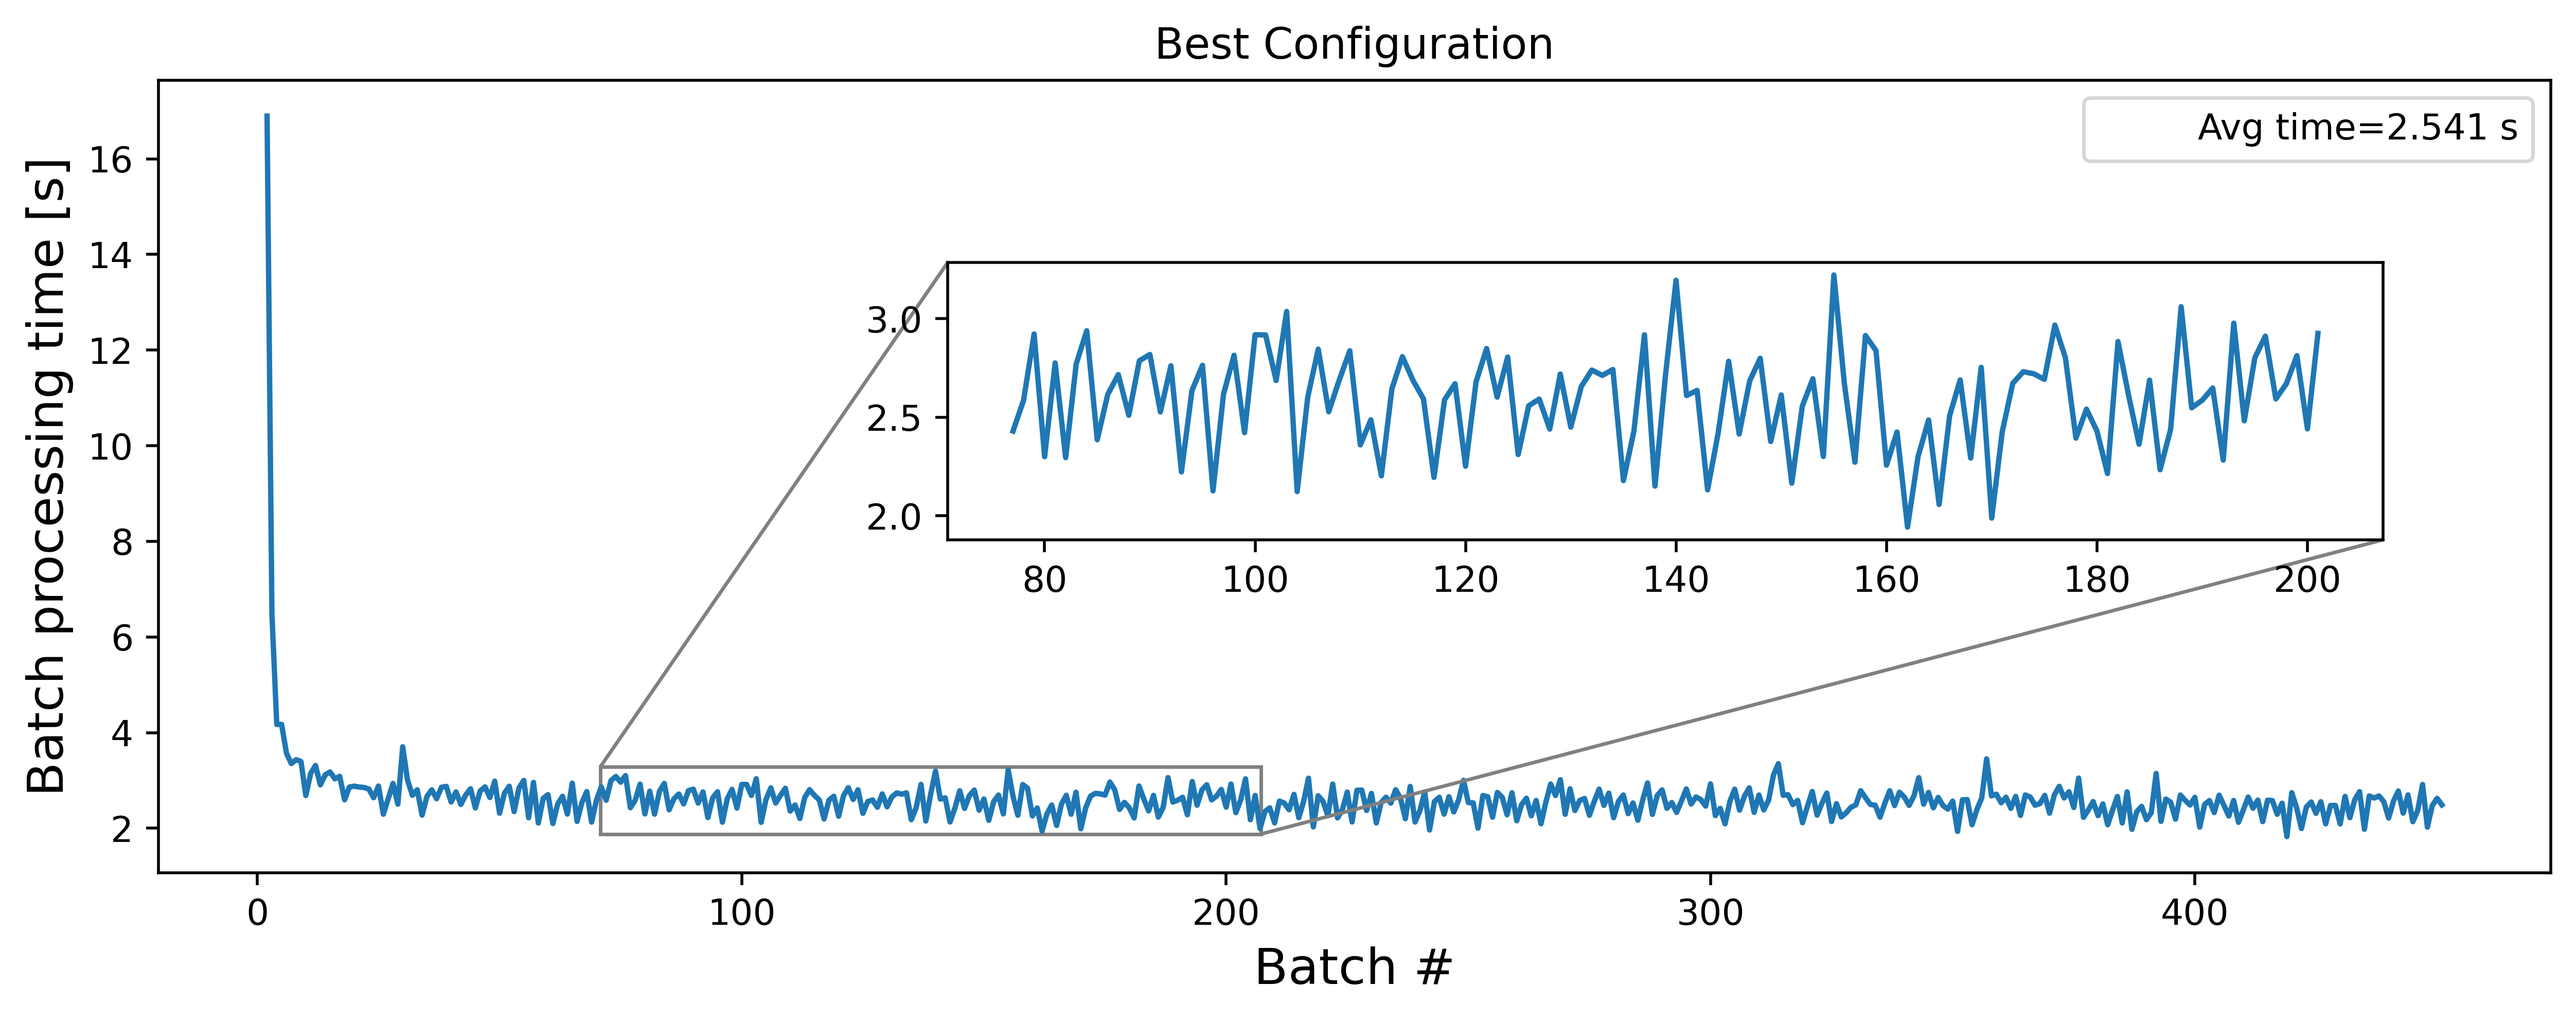

In [29]:
#using best configuration: 10 ex, 1 core, 10 sp, aT, 3 w, 10 kp, 5 sec of trigger, 1000 rows/sec

target_label_best = 'g'

# Filter the DataFrame based on the target label
df_target_best = df[df['Label'] == target_label_best]

# Plotting the single file
batch_durations_best = df_target_best['durationMs']
mean_batch_best = batch_durations_best[50:-1].mean()              #restrict the computation to the plateau

fig, ax = plt.subplots(figsize=(12, 4), dpi=500)
ax.plot(df_target_best['batchId'], batch_durations_best)

ax.set_xlabel('Batch #', fontsize=14)
ax.set_ylabel('Batch processing time [s]', fontsize=14)
ax.set_title('Best Configuration')
ax.plot([],[], ' ', label=f'Avg time={mean_batch_best:1.3f} s')
plt.legend()

# Create zoom inset
axins = ax.inset_axes([0.33, 0.42, 0.6, 0.35])
axins.plot(df_target_best['batchId'][75:200], batch_durations_best[75:200])


# Add border around the zoom inset
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

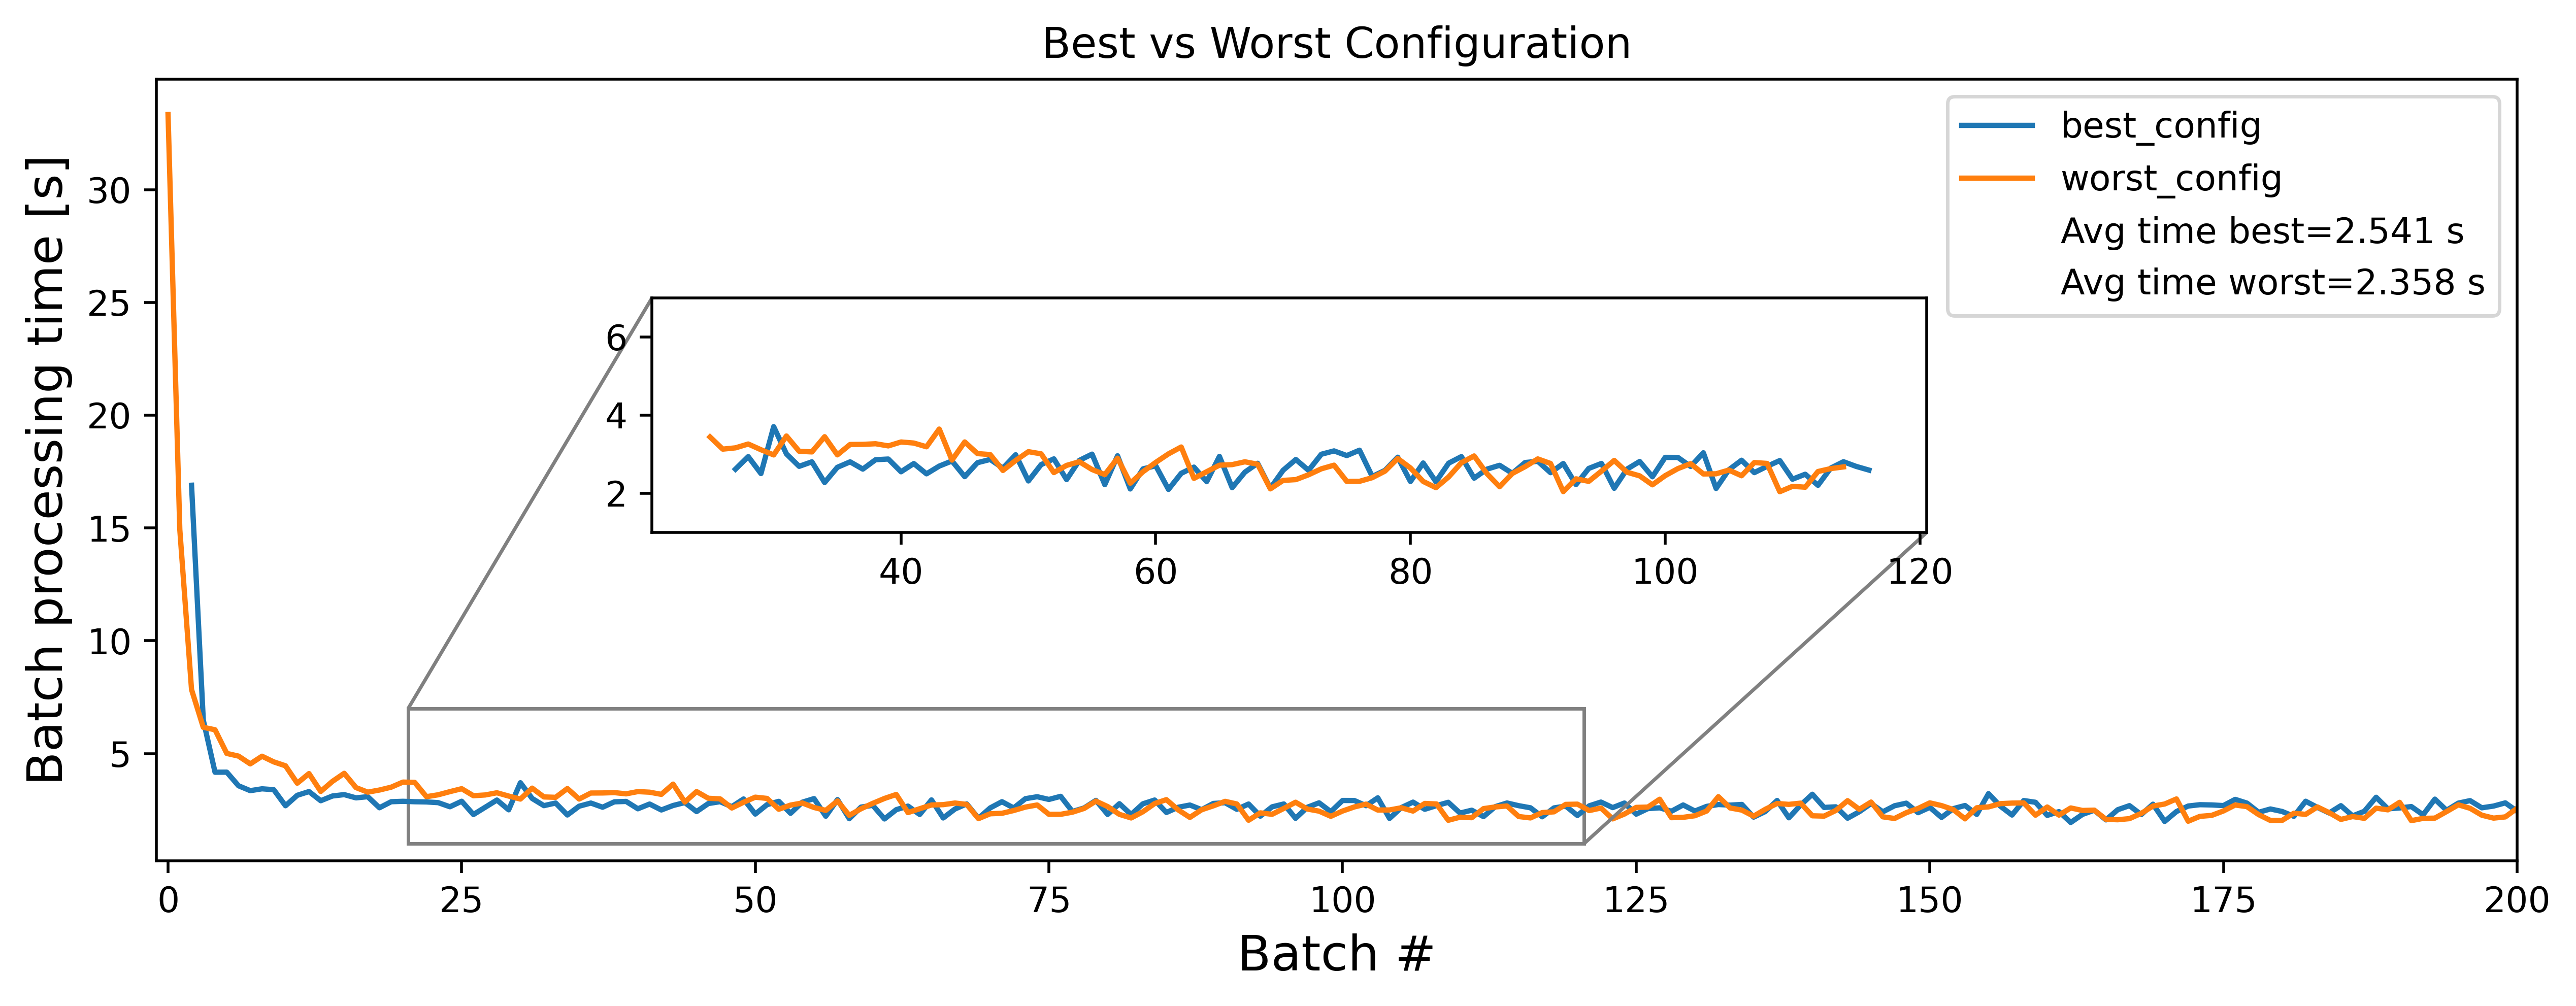

In [35]:
#comparing best vs worst configuration
#worst config: 10 ex, 1 core, 50 sp, 3 w, 1000 rows/sec, 5 sec of trigger

# Define the criteria
criteria_worst = {
    'Executors': 10,
    'Cores': 1,
    'ShufflePartitions': 200,
    'Trigger': 5,
    'Workers': 3,
    'Arrow': 'aT',
    'Batches': 5000;
    'KafkaPartitions':10
}

criteria_best = {
    'Executors': 10,
    'Cores': 1,
    'ShufflePartitions': 10,
    'Trigger': 5,
    'Workers': 3,
    'Arrow': 'aT',
    'Batches': 1000;
    'KafkaPartitions':10
}


target_label_best = 'g'
target_label_worst = 'n'

#df_target_worst = df[df['ShufflePartitions']  == 200 ]
#df_target_worst = df_target_worst[df_target_worst['KafkaPartitions']  == 10 ]



# Filter the DataFrame based on the target label
df_target_best = df[df['Label'] == target_label_best]
df_target_worst = df[df['Label'] == target_label_worst]

# Plotting the single file
batch_durations_best = df_target_best['durationMs']
mean_batch_best = batch_durations_best[50:-1].mean()

batch_durations_worst = df_target_worst['durationMs']
mean_batch_worst = batch_durations_worst[50:-1].mean()

fig, ax = plt.subplots(figsize=(12, 4), dpi=500)
ax.plot(df_target_best['batchId'], batch_durations_best, label='best_config')
ax.plot(df_target_worst['batchId'], batch_durations_worst, label='worst_config')

ax.set_xlabel('Batch #', fontsize=14)
ax.set_ylabel('Batch processing time [s]', fontsize=14)
ax.set_title('Best vs Worst Configuration')
ax.set_xlim(-1, 200)
ax.plot([],[], ' ', label=f'Avg time best={mean_batch_best:1.3f} s')
ax.plot([],[], ' ', label=f'Avg time worst={mean_batch_worst:1.3f} s')
plt.legend()

# Create zoom inset
axins = ax.inset_axes([0.21, 0.42, 0.54, 0.30])
axins.plot(df_target_best['batchId'][25:115], batch_durations_best[25:115])
axins.plot(df_target_worst['batchId'][25:115], batch_durations_worst[25:115])
axins.set_ylim(1, 7)

# Add border around the zoom inset
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

## Input and Processed Rows per Second

We plot the input and processed rows per second for two settings with different batch size but keeping the rest of the parameters fixed: 10 executors, 1 core, 10 shuffle partition, arrow = True, 3 workers, 10 Kafka partitions, 5 sec of trigger.

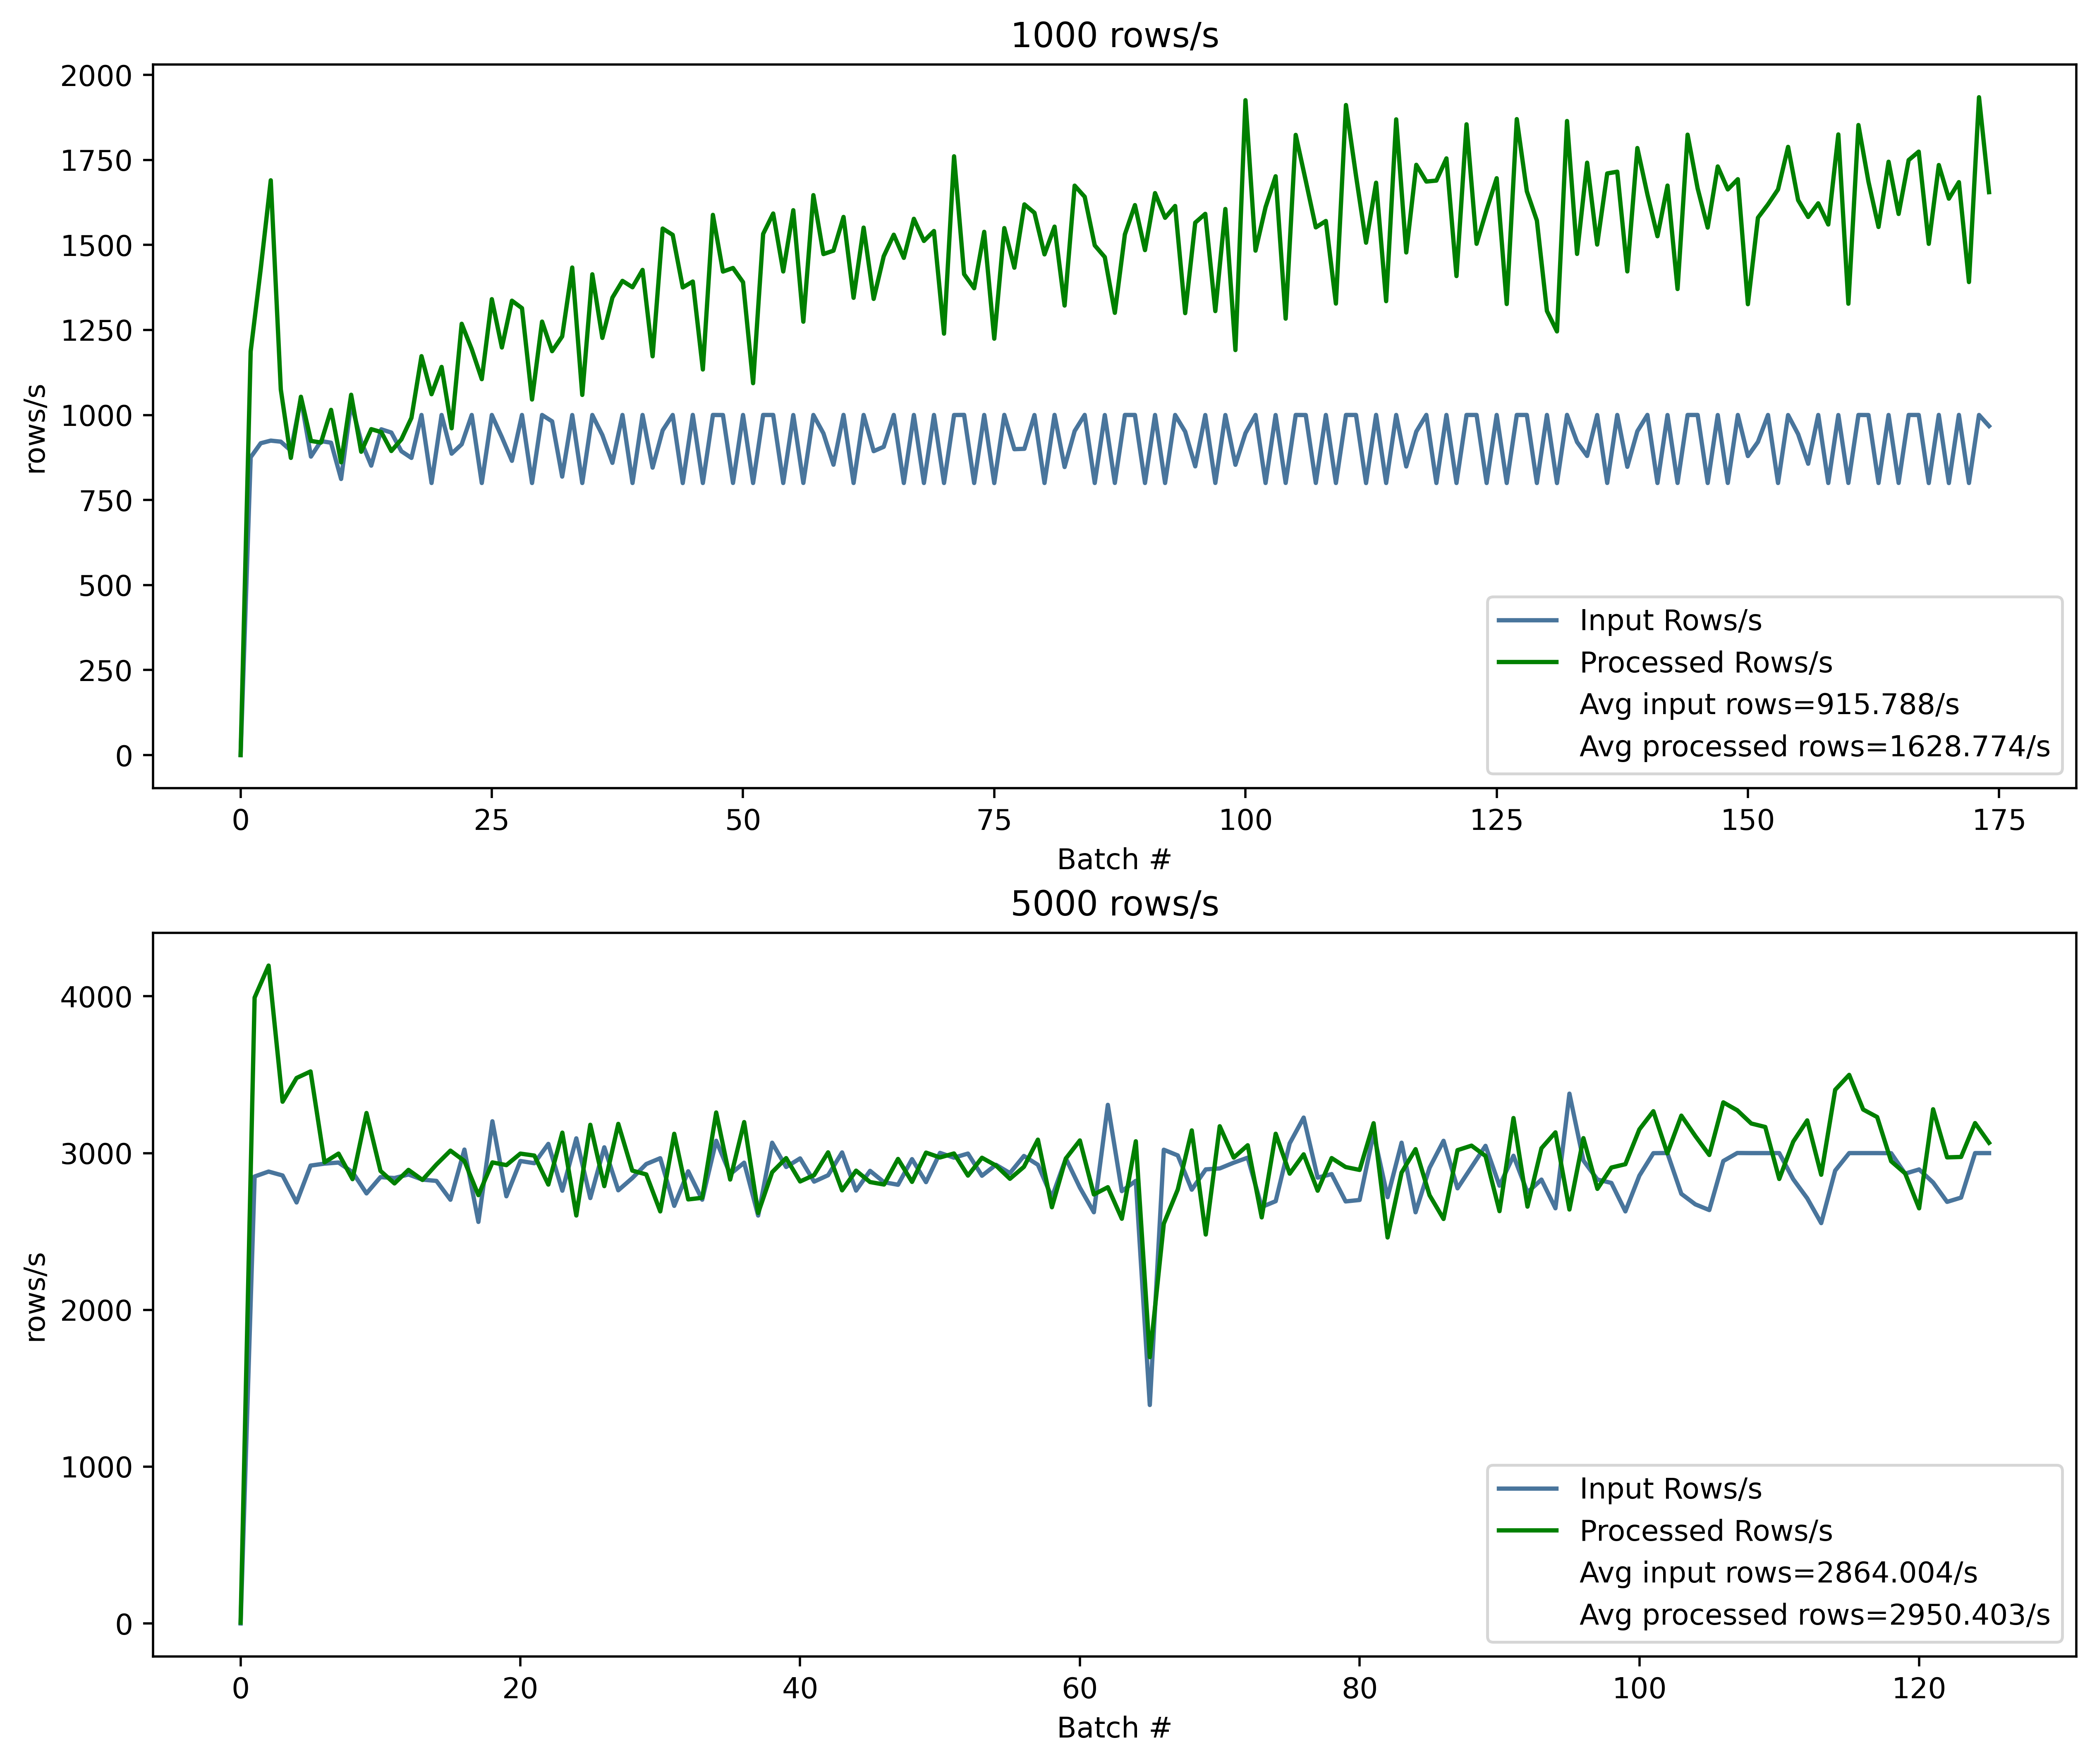

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), dpi=500)

#selecting the labels corresponding to 1000 and 5000 rows/s
target_label_5000 = 'n'
target_label_1000 = 'd'

# Filter the DataFrame based on the target label
df_target_5000 = df[df['Label'] == target_label_5000]
df_target_1000 = df[df['Label'] == target_label_1000]

mean_in_1000 = df_target_1000['inputRowsPerSecond'][50:-1].mean()
mean_out_1000 = df_target_1000['processedRowsPerSecond'][50:-1].mean()

mean_in_5000 = df_target_5000['inputRowsPerSecond'][50:-1].mean()
mean_out_5000 = df_target_5000['processedRowsPerSecond'][50:-1].mean()

ax[0].plot(df_target_1000['batchId'][0:175], df_target_1000['inputRowsPerSecond'][0:175], color='xkcd:dull blue', label='Input Rows/s')
ax[0].plot(df_target_1000['batchId'][0:175], df_target_1000['processedRowsPerSecond'][0:175], color='green', label='Processed Rows/s')
ax[0].set_xlabel('Batch #')
ax[0].set_ylabel('rows/s')
ax[0].set_title('1000 rows/s')  # Set the custom title
ax[0].plot([],[], ' ', label=f'Avg input rows={mean_in_1000:1.3f}/s')
ax[0].plot([],[], ' ', label=f'Avg processed rows={mean_out_1000:1.3f}/s')
ax[0].legend()

ax[1].plot(df_target_5000['batchId'], df_target_5000['inputRowsPerSecond'], color='xkcd:dull blue', label='Input Rows/s')
ax[1].plot(df_target_5000['batchId'], df_target_5000['processedRowsPerSecond'], color='green', label='Processed Rows/s')
ax[1].set_xlabel('Batch #')
ax[1].set_ylabel('rows/s')
ax[1].set_title('5000 rows/s')  # Set the custom title
ax[1].plot([],[], ' ', label=f'Avg input rows={mean_in_5000:1.3f}/s')
ax[1].plot([],[], ' ', label=f'Avg processed rows={mean_out_5000:1.3f}/s')
ax[1].legend()

plt.show()

## Box Plot of Duration Time

We plot the duration time by varying the number of Kafka partitions and keeping the number of shuffle partitions fixed, and vice versa.

### Varying Kafka Partitions

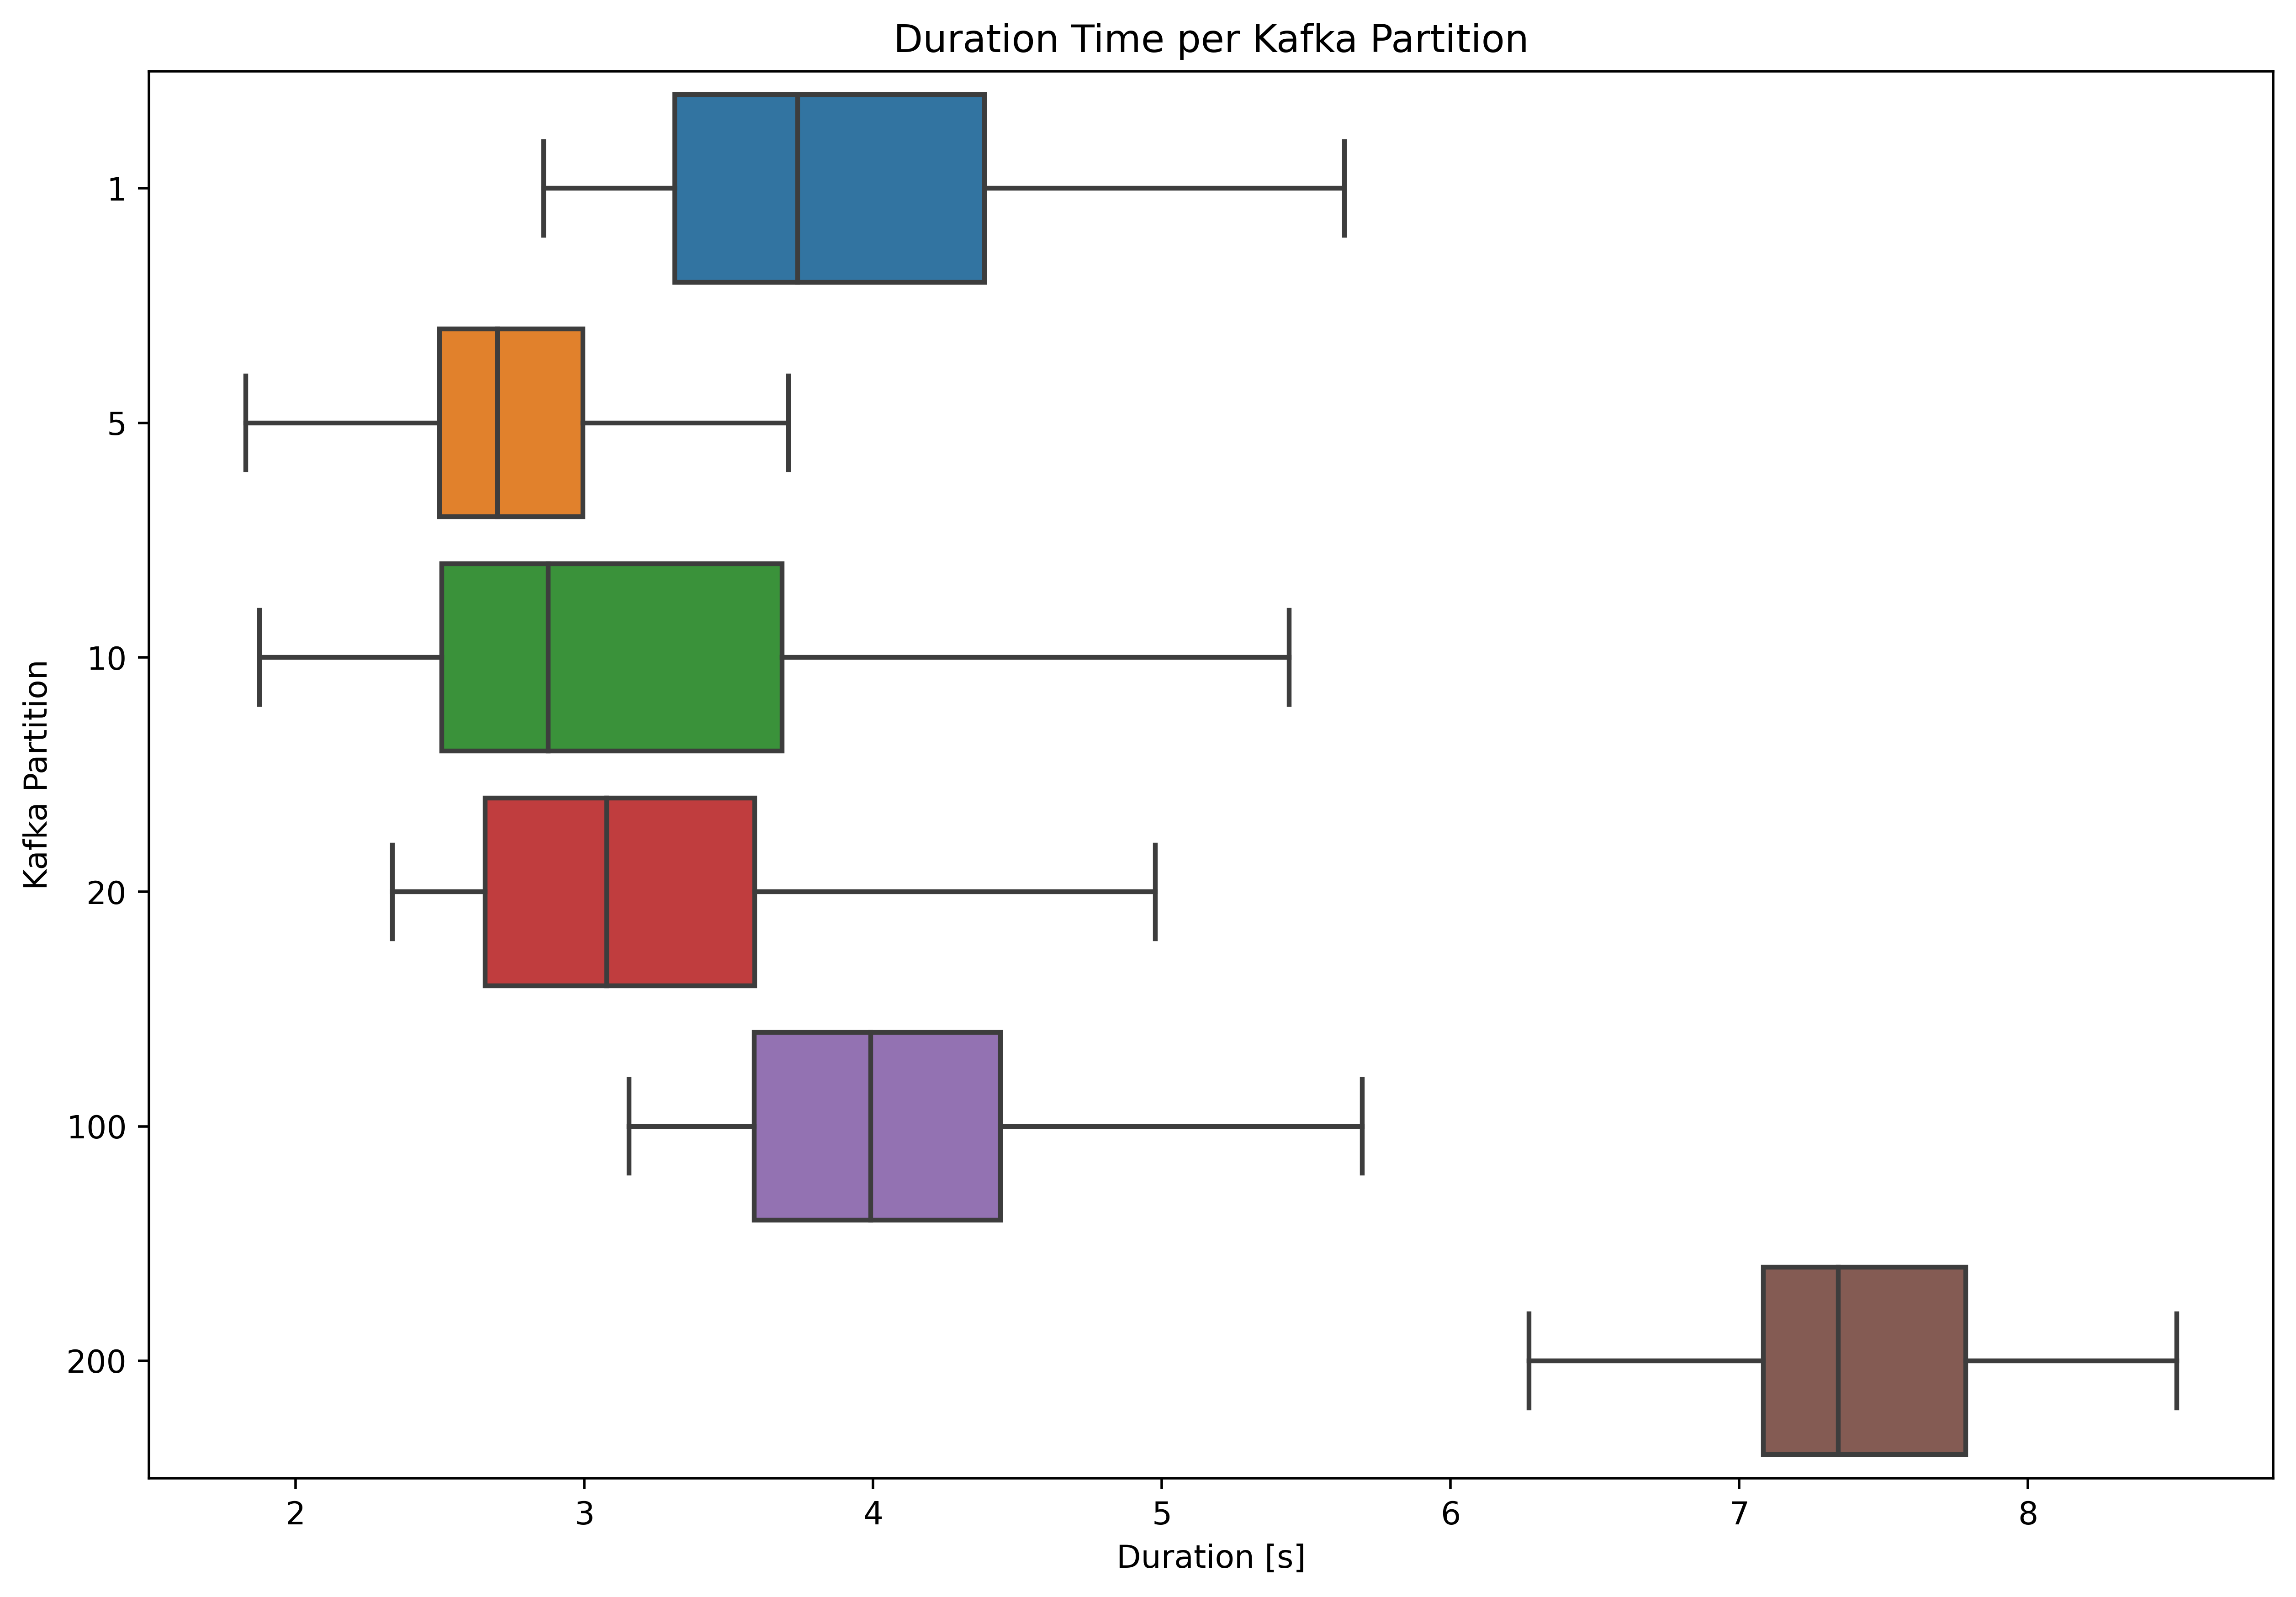

In [6]:
# Define the criteria
criteria = {
    'Executors': 10,
    'Cores': 1,
    'ShufflePartitions': 10,
    'Trigger': 5,
    'Workers': 3,
    'Arrow': 'aT',
    'Batches': 5000
}

# Convert the 'KafkaPartitions' column to categorical type
df['KafkaPartitions'] = df['KafkaPartitions'].astype('category')

filtered_df = df[df['KafkaPartitions'] != 6]
unique_partitions = filtered_df['KafkaPartitions'].unique()

# Create the box plot using seaborn
plt.figure(figsize=(12, 8), dpi=500)
sns.boxplot(data=filtered_df[50:-1], y=filtered_df['KafkaPartitions'].cat.remove_unused_categories(), x='durationMs', showfliers=False, orient='h')
plt.ylabel('Kafka Partition')
plt.xlabel('Duration [s]')
plt.title('Duration Time per Kafka Partition')

plt.show()

### Varying Shuffle Partitions

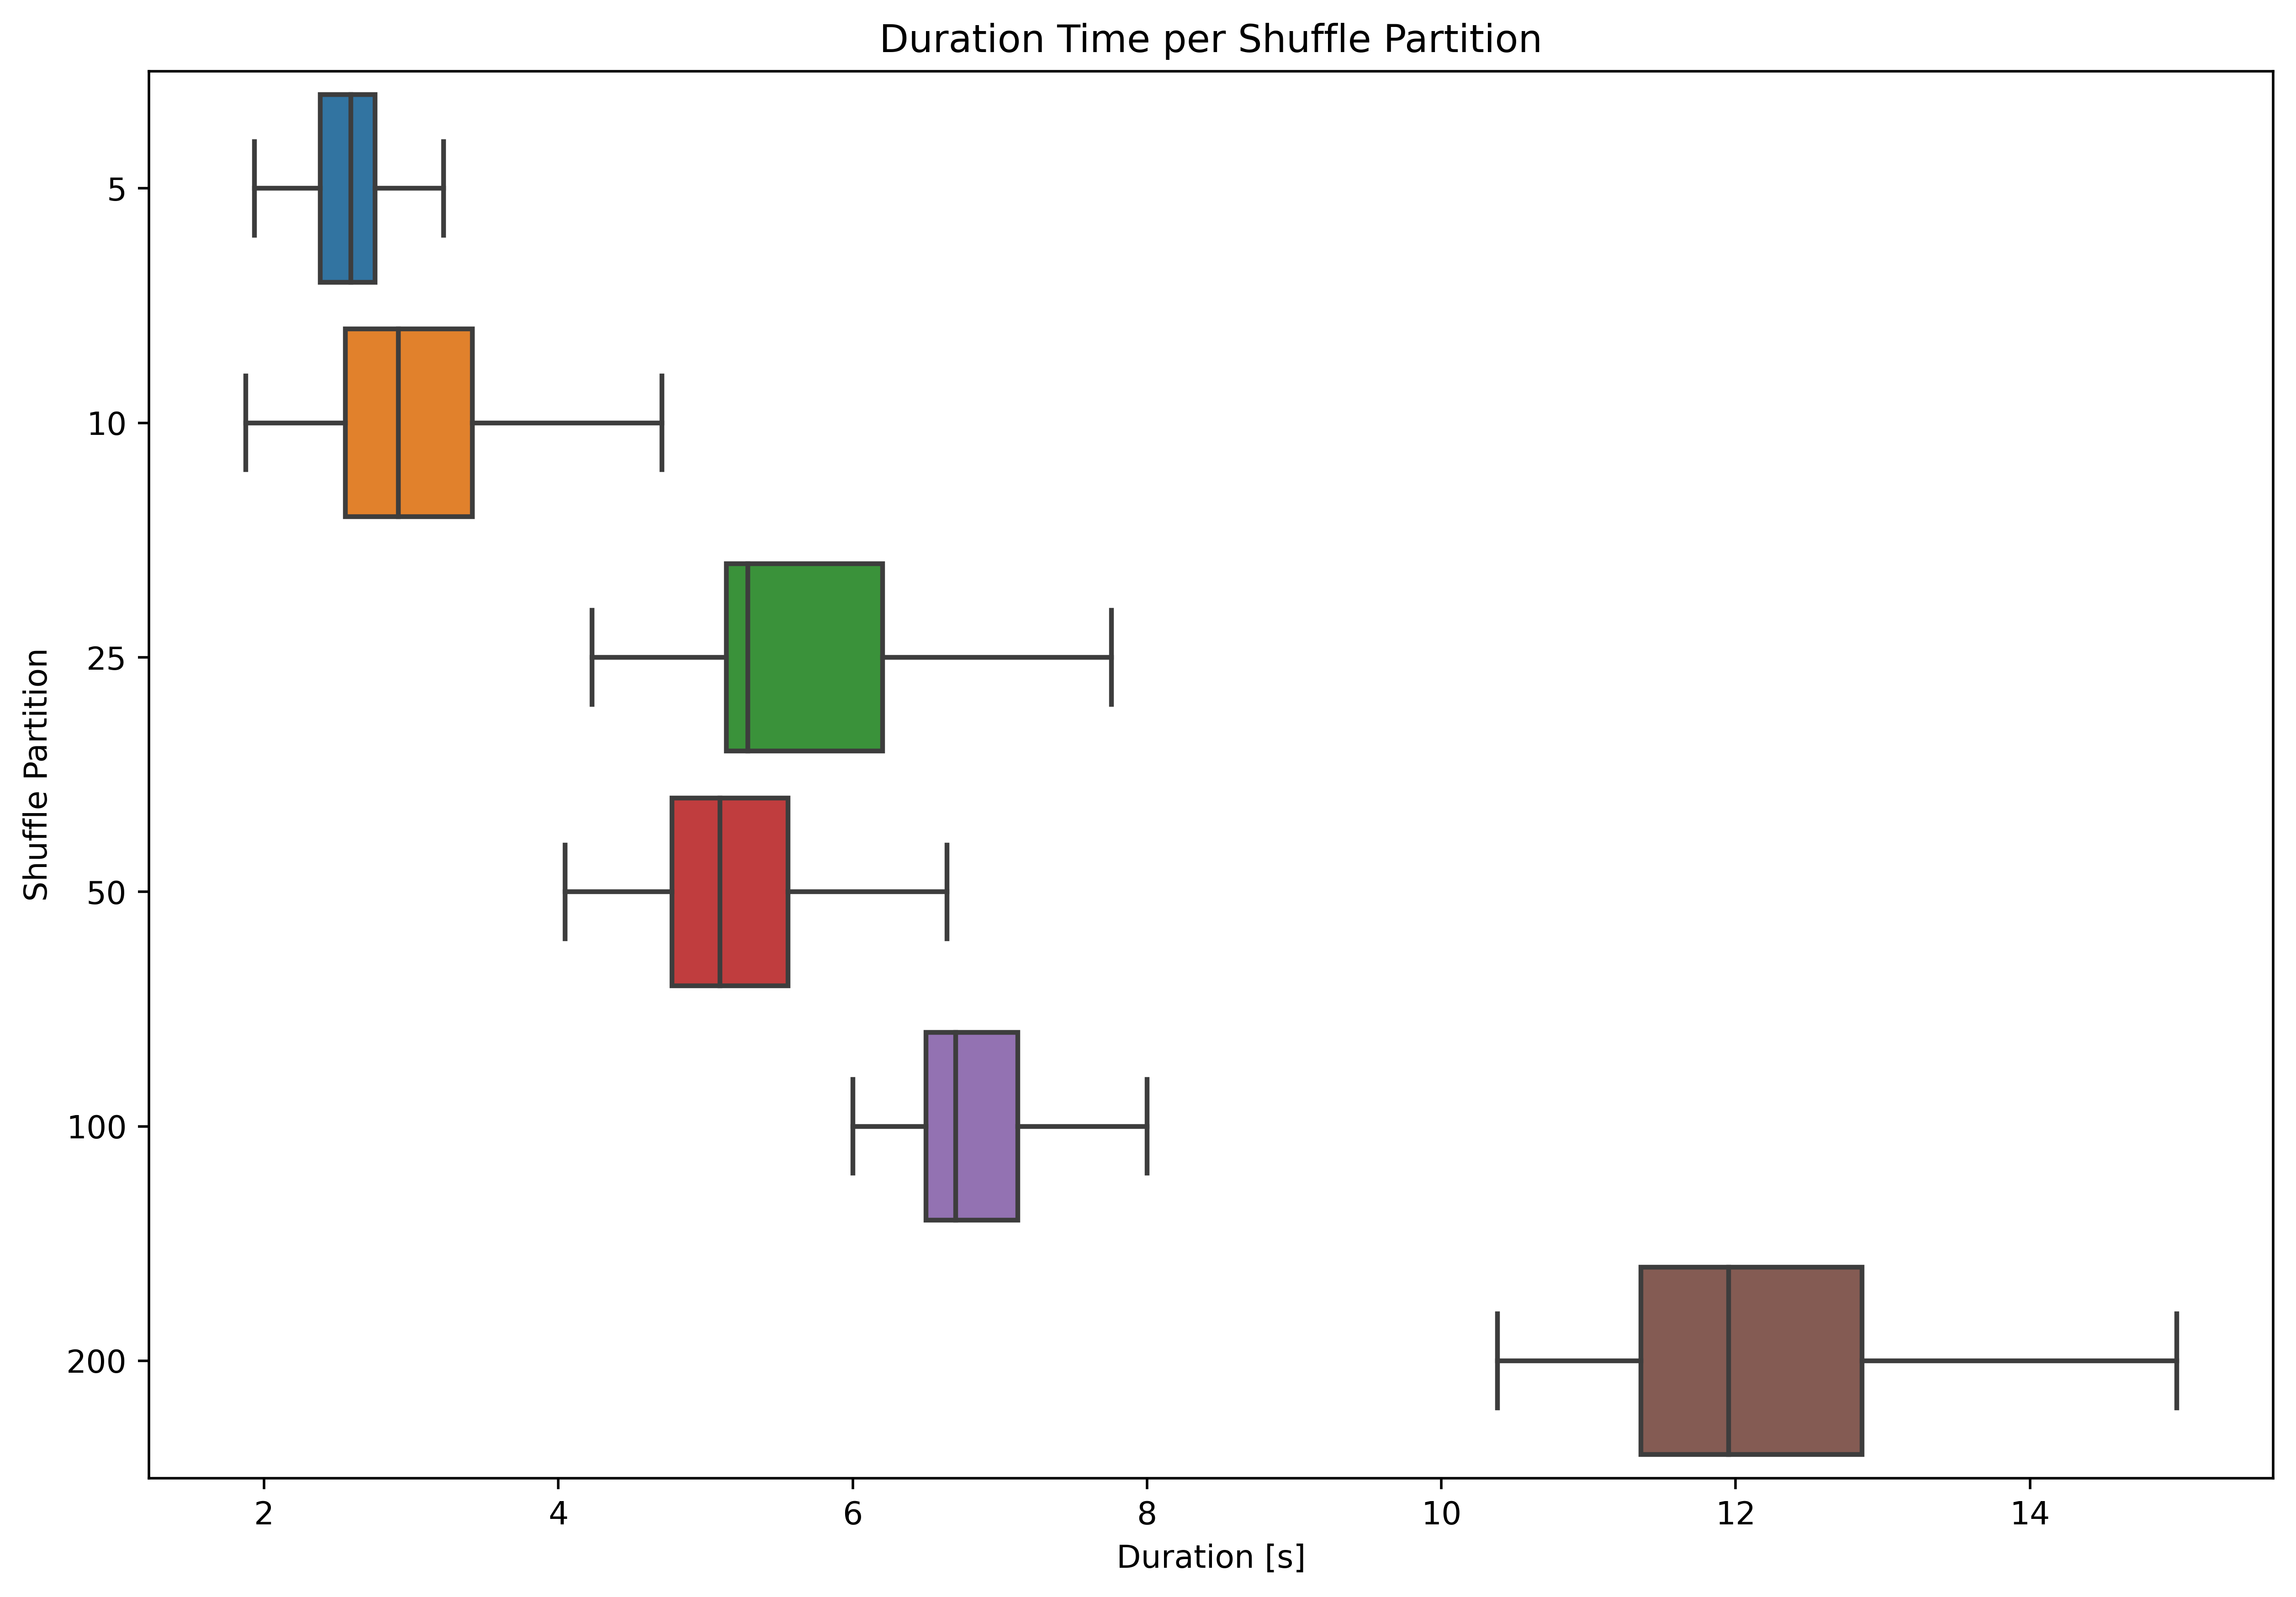

In [7]:
# Define the criteria
criteria = {
    'Executors': 10,
    'Cores': 1,
    'KafkaPartitions': 10,
    'Trigger': 5,
    'Workers': 3,
    'Arrow': 'aT',
    'Batches': 5000
}

# Convert the 'ShufflePartitions' column to categorical type
df['ShufflePartitions'] = df['ShufflePartitions'].astype('category')

filtered_df = df[df['ShufflePartitions'] != 6]
unique_partitions = filtered_df['ShufflePartitions'].unique()

# Create the box plot using seaborn
plt.figure(figsize=(12, 8), dpi=500)
sns.boxplot(data=filtered_df[50:-1], y=filtered_df['ShufflePartitions'].cat.remove_unused_categories(), x='durationMs', showfliers=False, orient='h')
plt.ylabel('Shuffle Partition')
plt.xlabel('Duration [s]')
plt.title('Duration Time per Shuffle Partition')

plt.show()